# Stage 2: Exploratory Data Analysis (EDA) — Don't Patronize Me! 

**Task:** Binary classification of Patronizing and Condescending Language (PCL) vs No PCL.

This notebook performs two distinct EDA techniques, each with:
1. **Visual/Tabular Evidence** — a figure or table
2. **Analysis** — a brief description of findings
3. **Impact Statement** — how the insight influences the classification approach

## Install and Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

import nltk
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid", palette="muted")
print("All libraries imported successfully.")

All libraries imported successfully.


## Load and Parse the PCL Dataset

Load `dontpatronizeme_pcl.tsv`, skipping the first 4 disclaimer lines. The columns are: `par_id`, `art_id`, `keyword`, `country_code`, `text`, `label` (0–4 graded scale).

In [2]:
BASE_DIR = "/Users/alexanderchow/Documents/Y3/60035_NLP/PCL_Detection"
DATA_DIR = f"{BASE_DIR}/data"
EDA_OUTPUT_DIR = f"{BASE_DIR}/eda_outputs"

pcl_df = pd.read_csv(
    f"{DATA_DIR}/dontpatronizeme_pcl.tsv",
    sep="\t",
    skiprows=4,
    header=None,
    names=["par_id", "art_id", "keyword", "country_code", "text", "label"],
    quoting=3  
)

pcl_df["par_id"] = pcl_df["par_id"].astype(int)
pcl_df["label"] = pcl_df["label"].astype(int)

print(f"Dataset shape: {pcl_df.shape}")
print(f"Label value counts:\n{pcl_df['label'].value_counts().sort_index()}")
pcl_df.head()

Dataset shape: (10469, 6)
Label value counts:
label
0    8529
1     947
2     144
3     458
4     391
Name: count, dtype: int64


,par_id,art_id,keyword,country_code,text,label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0


## Load Train/Dev Split Files

The practice splits contain `par_id` and multi-label annotations (7-category). We use only the `par_id` column to identify which paragraphs belong to train vs dev. The binary label comes from the main PCL file.

In [3]:
train_splits = pd.read_csv(f"{BASE_DIR}/practice splits/train_semeval_parids-labels.csv")
dev_splits = pd.read_csv(f"{BASE_DIR}/practice splits/dev_semeval_parids-labels.csv")

train_splits["par_id"] = train_splits["par_id"].astype(int)
dev_splits["par_id"] = dev_splits["par_id"].astype(int)

print(f"Train split par_ids: {len(train_splits)}")
print(f"Dev split par_ids:   {len(dev_splits)}")
print(f"\nTrain split sample:\n{train_splits.head()}")
print(f"\nDev split sample:\n{dev_splits.head()}")

Train split par_ids: 8375
Dev split par_ids:   2094

Train split sample:
   par_id                  label
0    4341  [1, 0, 0, 1, 0, 0, 0]
1    4136  [0, 1, 0, 0, 0, 0, 0]
2   10352  [1, 0, 0, 0, 0, 1, 0]
3    8279  [0, 0, 0, 1, 0, 0, 0]
4    1164  [1, 0, 0, 1, 1, 1, 0]

Dev split sample:
   par_id                  label
0    4046  [1, 0, 0, 1, 0, 0, 0]
1    1279  [0, 1, 0, 0, 0, 0, 0]
2    8330  [0, 0, 1, 0, 0, 0, 0]
3    4063  [1, 0, 0, 1, 1, 1, 0]
4    4089  [1, 0, 0, 0, 0, 0, 0]


## Merge Data and Create Binary Labels

Following the paper's grouping:
- Labels **{0, 1}** → **0 (No PCL)**
- Labels **{2, 3, 4}** → **1 (PCL)**

In [4]:
pcl_df["binary_label"] = (pcl_df["label"] >= 2).astype(int)

train_ids = set(train_splits["par_id"].values)
dev_ids = set(dev_splits["par_id"].values)

train_df = pcl_df[pcl_df["par_id"].isin(train_ids)].copy()
dev_df = pcl_df[pcl_df["par_id"].isin(dev_ids)].copy()

print(f"Full dataset:  {len(pcl_df)} samples")
print(f"Train set:     {len(train_df)} samples")
print(f"Dev set:       {len(dev_df)} samples")
print(f"Unassigned:    {len(pcl_df) - len(train_df) - len(dev_df)} samples")
print(f"\nTrain binary label distribution:\n{train_df['binary_label'].value_counts().sort_index()}")
print(f"\nDev binary label distribution:\n{dev_df['binary_label'].value_counts().sort_index()}")

Full dataset:  10469 samples
Train set:     8375 samples
Dev set:       2094 samples
Unassigned:    0 samples

Train binary label distribution:
binary_label
0    7581
1     794
Name: count, dtype: int64

Dev binary label distribution:
binary_label
0    1895
1     199
Name: count, dtype: int64


## EDA Technique 1 — Basic Statistical Profiling

### 1a. Token Count

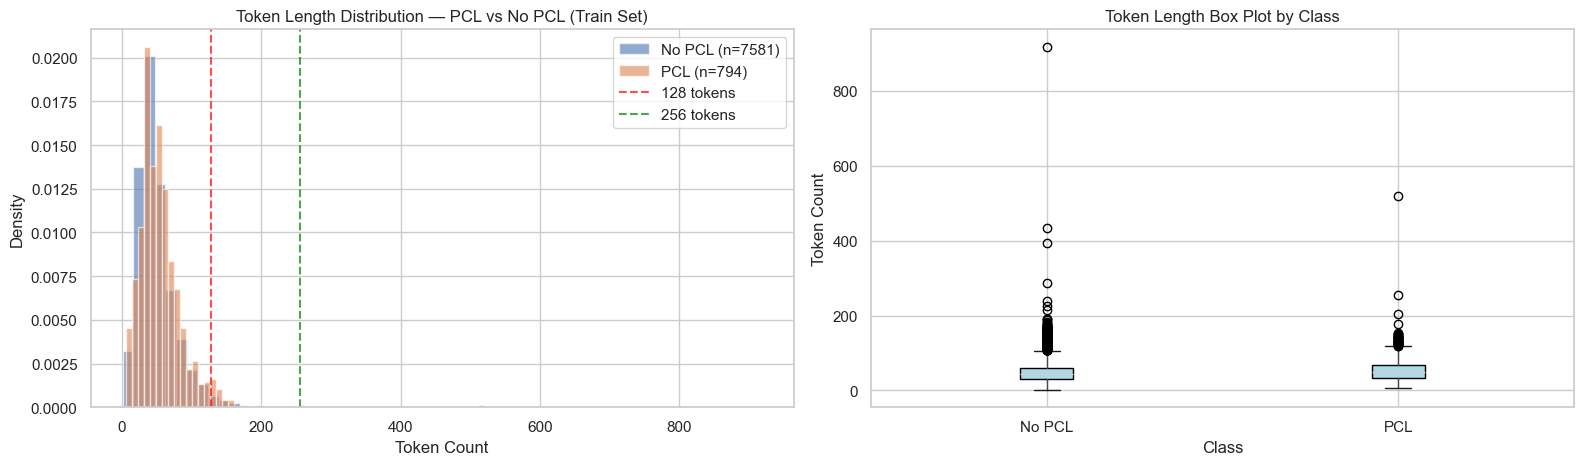


=== Token Length Summary Statistics (Train Set) ===
Metric No PCL  PCL Overall
 Count   7581  794    8375
  Mean   49.4 55.1    50.0
Median     43   49      43
   Std   29.8 34.1    30.2
   Min      1    6       1
   Max    918  520     918
   P25     31   34      31
   P75     61   68      62
   P95    103  116     104
   P99    144  145     145


In [5]:
train_df["tokens"] = train_df["text"].apply(lambda x: word_tokenize(str(x)))
train_df["token_count"] = train_df["tokens"].apply(len)

dev_df["tokens"] = dev_df["text"].apply(lambda x: word_tokenize(str(x)))
dev_df["token_count"] = dev_df["tokens"].apply(len)

no_pcl_lengths = train_df[train_df["binary_label"] == 0]["token_count"]
pcl_lengths = train_df[train_df["binary_label"] == 1]["token_count"]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(no_pcl_lengths, bins=60, alpha=0.6, label=f"No PCL (n={len(no_pcl_lengths)})", color="#4C72B0", density=True)
axes[0].hist(pcl_lengths, bins=60, alpha=0.6, label=f"PCL (n={len(pcl_lengths)})", color="#DD8452", density=True)
axes[0].set_xlabel("Token Count")
axes[0].set_ylabel("Density")
axes[0].set_title("Token Length Distribution — PCL vs No PCL (Train Set)")
axes[0].legend()
axes[0].axvline(x=128, color="red", linestyle="--", alpha=0.7, label="128 tokens")
axes[0].axvline(x=256, color="green", linestyle="--", alpha=0.7, label="256 tokens")
axes[0].legend()

train_df.boxplot(column="token_count", by="binary_label", ax=axes[1],
                  patch_artist=True,
                  boxprops=dict(facecolor="lightblue"))
axes[1].set_xticklabels(["No PCL", "PCL"])
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Token Count")
axes[1].set_title("Token Length Box Plot by Class")
plt.suptitle("")

plt.tight_layout()
plt.savefig(f"{EDA_OUTPUT_DIR}/token_length_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

all_lengths = train_df["token_count"]
stats = pd.DataFrame({
    "Metric": ["Count", "Mean", "Median", "Std", "Min", "Max", "P25", "P75", "P95", "P99"],
    "No PCL": [
        len(no_pcl_lengths), f"{no_pcl_lengths.mean():.1f}", f"{no_pcl_lengths.median():.0f}",
        f"{no_pcl_lengths.std():.1f}", no_pcl_lengths.min(), no_pcl_lengths.max(),
        f"{no_pcl_lengths.quantile(0.25):.0f}", f"{no_pcl_lengths.quantile(0.75):.0f}",
        f"{no_pcl_lengths.quantile(0.95):.0f}", f"{no_pcl_lengths.quantile(0.99):.0f}"
    ],
    "PCL": [
        len(pcl_lengths), f"{pcl_lengths.mean():.1f}", f"{pcl_lengths.median():.0f}",
        f"{pcl_lengths.std():.1f}", pcl_lengths.min(), pcl_lengths.max(),
        f"{pcl_lengths.quantile(0.25):.0f}", f"{pcl_lengths.quantile(0.75):.0f}",
        f"{pcl_lengths.quantile(0.95):.0f}", f"{pcl_lengths.quantile(0.99):.0f}"
    ],
    "Overall": [
        len(all_lengths), f"{all_lengths.mean():.1f}", f"{all_lengths.median():.0f}",
        f"{all_lengths.std():.1f}", all_lengths.min(), all_lengths.max(),
        f"{all_lengths.quantile(0.25):.0f}", f"{all_lengths.quantile(0.75):.0f}",
        f"{all_lengths.quantile(0.95):.0f}", f"{all_lengths.quantile(0.99):.0f}"
    ]
})
print("\n=== Token Length Summary Statistics (Train Set) ===")
print(stats.to_string(index=False))

### 1b. Vocabulary Size

In [6]:
# Vocabulary size
print("\n=== Vocabulary Size Statistics (Train Set) ===")
all_tokens_no_pcl = [t.lower() for tokens in train_df[train_df["binary_label"]==0]["tokens"] for t in tokens]
all_tokens_pcl = [t.lower() for tokens in train_df[train_df["binary_label"]==1]["tokens"] for t in tokens]
print(f"\nVocabulary size (No PCL): {len(set(all_tokens_no_pcl)):,}")
print(f"Vocabulary size (PCL):    {len(set(all_tokens_pcl)):,}")
print(f"Vocabulary size (Total):  {len(set(all_tokens_no_pcl + all_tokens_pcl)):,}")


=== Vocabulary Size Statistics (Train Set) ===

Vocabulary size (No PCL): 27,810
Vocabulary size (PCL):    6,969
Vocabulary size (Total):  29,311


### 1c. Class Distribution Analysis

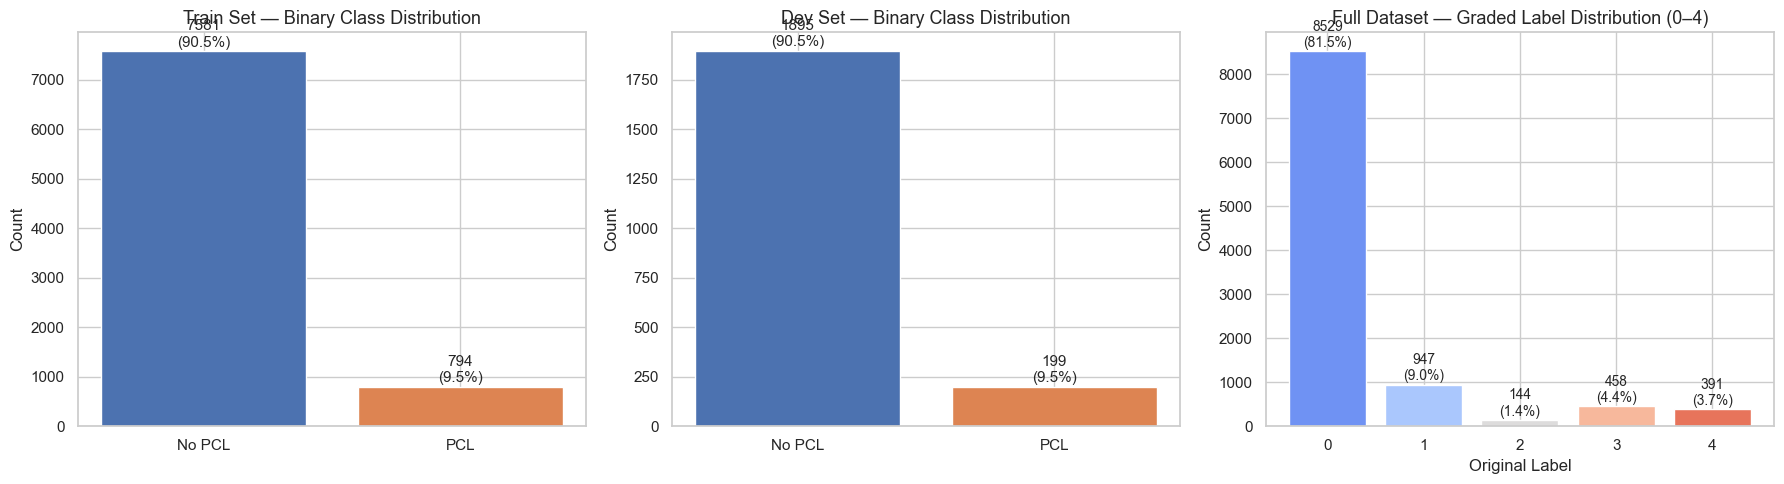


=== Class Imbalance Summary ===
Train: No PCL = 7581, PCL = 794, Ratio = 9.5:1
Dev:   No PCL = 1895, PCL = 199, Ratio = 9.5:1


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Binary class distribution: Train ---
train_counts = train_df["binary_label"].value_counts().sort_index()
labels_map = {0: "No PCL", 1: "PCL"}
colors = ["#4C72B0", "#DD8452"]

bars = axes[0].bar([labels_map[i] for i in train_counts.index], train_counts.values, color=colors)
for bar, count in zip(bars, train_counts.values):
    pct = count / train_counts.sum() * 100
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
                 f"{count}\n({pct:.1f}%)", ha="center", va="bottom", fontsize=11)
axes[0].set_title("Train Set — Binary Class Distribution", fontsize=13)
axes[0].set_ylabel("Count")

# --- Binary class distribution: Dev ---
dev_counts = dev_df["binary_label"].value_counts().sort_index()
bars = axes[1].bar([labels_map[i] for i in dev_counts.index], dev_counts.values, color=colors)
for bar, count in zip(bars, dev_counts.values):
    pct = count / dev_counts.sum() * 100
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                 f"{count}\n({pct:.1f}%)", ha="center", va="bottom", fontsize=11)
axes[1].set_title("Dev Set — Binary Class Distribution", fontsize=13)
axes[1].set_ylabel("Count")

# --- Original graded label distribution (0-4) on full dataset ---
graded_counts = pcl_df["label"].value_counts().sort_index()
bars = axes[2].bar(graded_counts.index.astype(str), graded_counts.values,
                    color=sns.color_palette("coolwarm", 5))
for bar, count in zip(bars, graded_counts.values):
    pct = count / graded_counts.sum() * 100
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
                 f"{count}\n({pct:.1f}%)", ha="center", va="bottom", fontsize=10)
axes[2].set_title("Full Dataset — Graded Label Distribution (0–4)", fontsize=13)
axes[2].set_xlabel("Original Label")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.savefig(f"{EDA_OUTPUT_DIR}/class_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

imbalance_ratio = train_counts[0] / train_counts[1]
print(f"\n=== Class Imbalance Summary ===")
print(f"Train: No PCL = {train_counts[0]}, PCL = {train_counts[1]}, Ratio = {imbalance_ratio:.1f}:1")
imbalance_ratio_dev = dev_counts[0] / dev_counts[1]
print(f"Dev:   No PCL = {dev_counts[0]}, PCL = {dev_counts[1]}, Ratio = {imbalance_ratio_dev:.1f}:1")

### Technique 1 — Analysis & Impact Statement

**Analysis:**
- The dataset exhibits severe class imbalance: the No PCL class vastly outnumbers the PCL class (a 9.5:1 ratio in both train and dev). Only ~10% of paragraphs contain patronizing/condescending language.
- The graded label distribution shows that labels 0 and 1 (mapped to No PCL) dominate, while labels 2, 3, and 4 are much rarer.
- Token lengths overlap considerably between classes, but PCL texts tend to be slightly longer on average (mean 55.1 vs 49.4 tokens), suggesting patronizing language may involve more elaborate phrasing (e.g., explanations, metaphors, authority claims).
- The 95th percentile token length is 104 tokens and the 99th percentile is 145 tokens, informing our `max_length` parameter for transformer tokenizers.

**Impact Statement:**
1. **Class weighting / resampling** is essential. A naïve model predicting "No PCL" for everything would achieve ~90% accuracy but 0% recall on the minority class. We must use **stratified splits**, **class-weighted loss**, or **oversampling** (e.g., SMOTE, random oversampling of PCL examples).
2. **max_length** for transformer models should be set to approximately the 95th–99th percentile token count to balance coverage vs. computational cost. A value of 128–256 subword tokens is a reasonable starting point.
3. The large vocabulary (29,311 unique tokens) suggests a **pre-trained language model** (e.g., BERT, RoBERTa) would be preferable to training embeddings from scratch.

## EDA Technique 2 — Lexical Analysis (The "Word" Level)

### 2a. Bigram Analysis

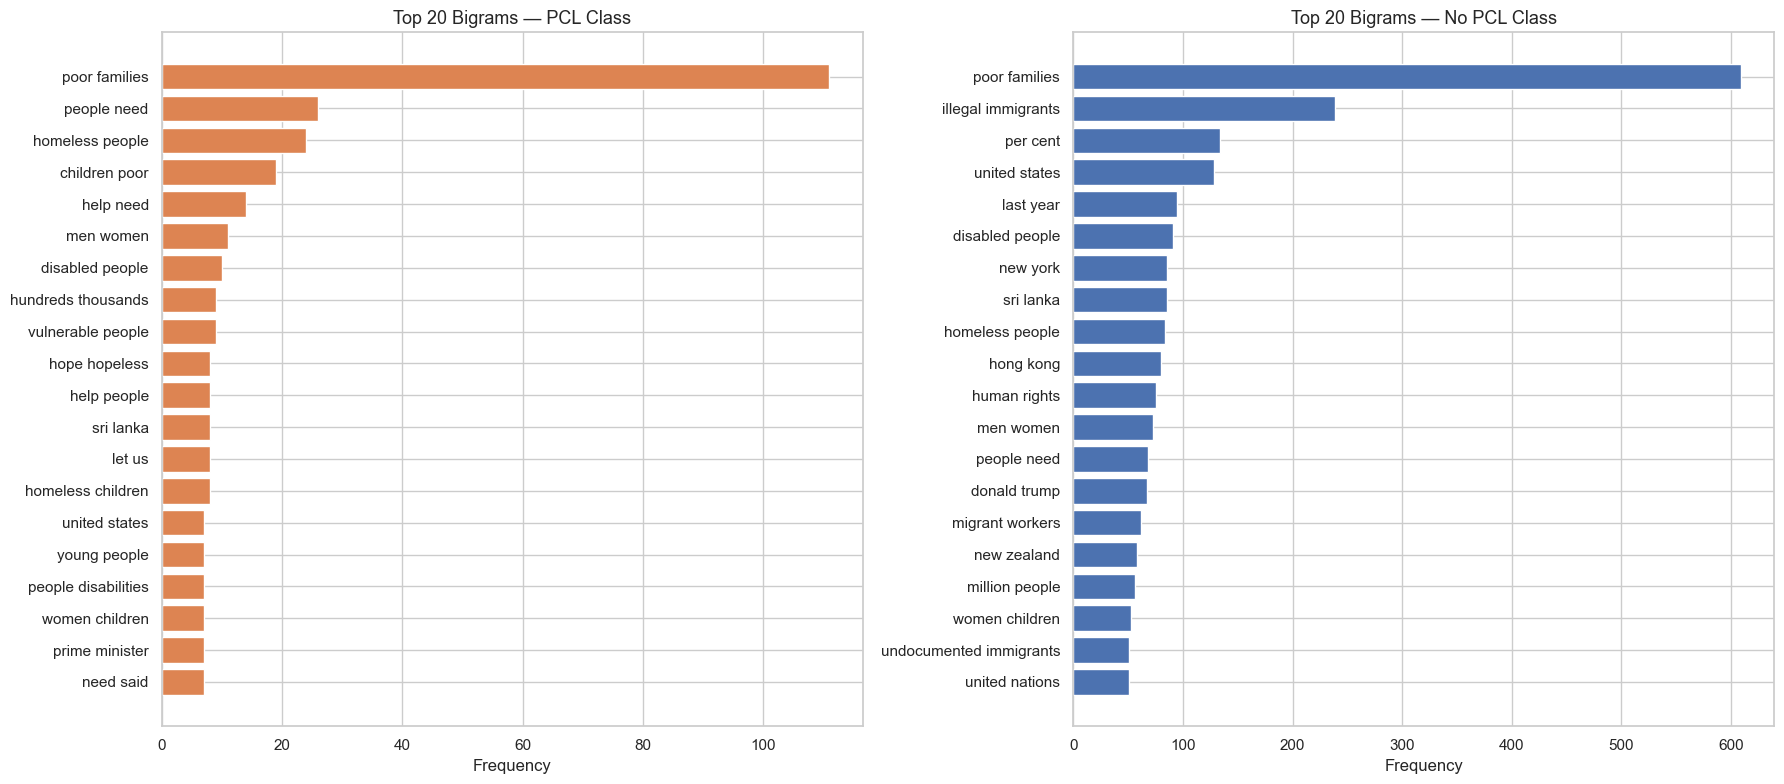

In [8]:
stop_words = set(stopwords.words("english"))
stop_words.update([".", ",", ":", ";", "!", "?", "'", "\"", "``", "''", "--", "-",
                    "(", ")", "'s", "n't", "'re", "'ve", "'ll", "'m", "...", "'d",
                    "``", "''", "'", "'", """, """, "—", "–"])

def get_filtered_tokens(text):
    """Lowercase, tokenize, and remove stopwords + punctuation."""
    tokens = word_tokenize(str(text).lower())
    return [t for t in tokens if t not in stop_words and t.isalpha() and len(t) > 1]

def get_top_ngrams(texts, n=2, top_k=20):
    """Extract top-k n-grams from a series of texts."""
    all_ngrams = []
    for text in texts:
        tokens = get_filtered_tokens(text)
        all_ngrams.extend(list(ngrams(tokens, n)))
    return Counter(all_ngrams).most_common(top_k)

pcl_texts = train_df[train_df["binary_label"] == 1]["text"]
no_pcl_texts = train_df[train_df["binary_label"] == 0]["text"]

top_bigrams_pcl = get_top_ngrams(pcl_texts, n=2, top_k=20)
top_bigrams_no_pcl = get_top_ngrams(no_pcl_texts, n=2, top_k=20)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

bigram_labels_pcl = [" ".join(bg) for bg, _ in reversed(top_bigrams_pcl)]
bigram_counts_pcl = [c for _, c in reversed(top_bigrams_pcl)]
axes[0].barh(bigram_labels_pcl, bigram_counts_pcl, color="#DD8452")
axes[0].set_title("Top 20 Bigrams — PCL Class", fontsize=13)
axes[0].set_xlabel("Frequency")

bigram_labels_no = [" ".join(bg) for bg, _ in reversed(top_bigrams_no_pcl)]
bigram_counts_no = [c for _, c in reversed(top_bigrams_no_pcl)]
axes[1].barh(bigram_labels_no, bigram_counts_no, color="#4C72B0")
axes[1].set_title("Top 20 Bigrams — No PCL Class", fontsize=13)
axes[1].set_xlabel("Frequency")

plt.tight_layout()
plt.savefig(f"{EDA_OUTPUT_DIR}/bigram_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

### 2b. Stop Word Density

=== Stopword (Filler) Count — Train Set ===
              count  mean  median   p25   p75   p95
binary_label                                       
No PCL         7581 18.15   15.00 11.00 23.00 41.00
PCL             794 21.71   19.00 12.00 27.00 46.35

High filler-count (>= 20) samples: 34.6% of train set


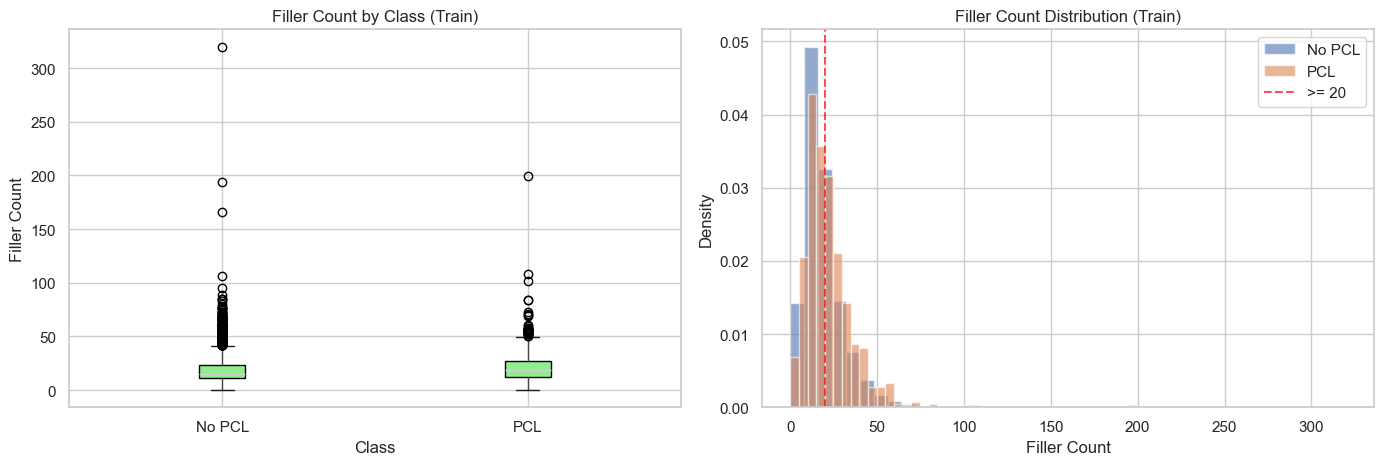

In [9]:
# Stopword (filler) count: number of stopword tokens per text
if "tokens" not in train_df.columns:
    train_df["tokens"] = train_df["text"].apply(lambda x: word_tokenize(str(x)))
if "tokens" not in dev_df.columns:
    dev_df["tokens"] = dev_df["text"].apply(lambda x: word_tokenize(str(x)))

filler_words = set(stopwords.words("english"))

def filler_count(tokens):
    return sum(1 for t in tokens if t.lower() in filler_words)

train_df["filler_count"] = train_df["tokens"].apply(filler_count)
dev_df["filler_count"] = dev_df["tokens"].apply(filler_count)

summary = train_df.groupby("binary_label")["filler_count"].agg(
    count="count",
    mean="mean",
    median="median",
    p25=lambda s: s.quantile(0.25),
    p75=lambda s: s.quantile(0.75),
    p95=lambda s: s.quantile(0.95),
).rename(index={0: "No PCL", 1: "PCL"})

print("=== Stopword (Filler) Count — Train Set ===")
print(summary.to_string(float_format=lambda v: f"{v:.2f}"))

# High-count share (absolute count)
threshold = 20
high_count_rate = (train_df["filler_count"] >= threshold).mean() * 100
print(f"\nHigh filler-count (>= {threshold}) samples: {high_count_rate:.1f}% of train set")

# Visualize distribution by class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_df.boxplot(column="filler_count", by="binary_label", ax=axes[0],
                  patch_artist=True,
                  boxprops=dict(facecolor="lightgreen"))
axes[0].set_xticklabels(["No PCL", "PCL"])
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Filler Count")
axes[0].set_title("Filler Count by Class (Train)")
plt.suptitle("")

no_pcl_fc = train_df[train_df["binary_label"] == 0]["filler_count"]
pcl_fc = train_df[train_df["binary_label"] == 1]["filler_count"]
axes[1].hist(no_pcl_fc, bins=40, alpha=0.6, density=True, label="No PCL", color="#4C72B0")
axes[1].hist(pcl_fc, bins=40, alpha=0.6, density=True, label="PCL", color="#DD8452")
axes[1].axvline(x=threshold, color="red", linestyle="--", alpha=0.7, label=f">= {threshold}")
axes[1].set_xlabel("Filler Count")
axes[1].set_ylabel("Density")
axes[1].set_title("Filler Count Distribution (Train)")
axes[1].legend()

plt.tight_layout()
plt.show()

### 2c. Word Clouds & Frequency

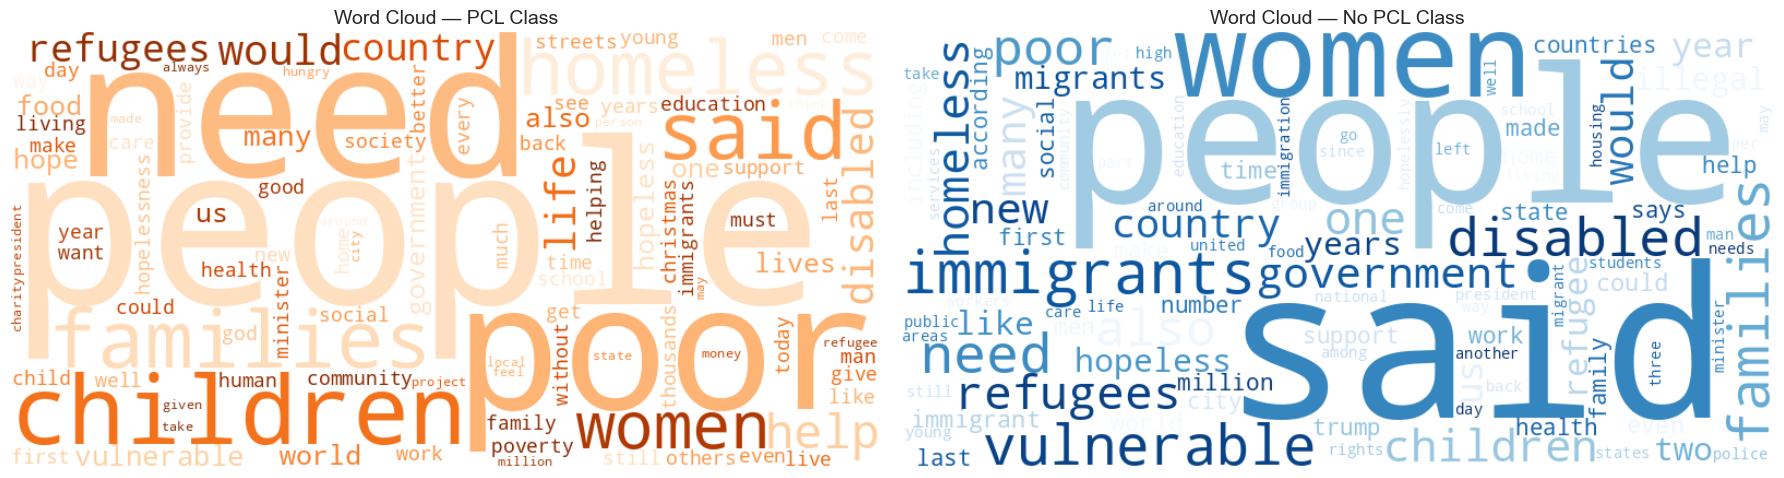

=== Keyword × Binary Label Cross-Tabulation (Train Set) ===
               No PCL  PCL  Total  PCL Rate (%)
keyword                                        
homeless          716  149    865          17.2
in-need           713  143    856          16.7
poor-families     607  112    719          15.6
hopeless          690   98    788          12.4
All              7581  794   8375           9.5
refugee           807   73    880           8.3
disabled          767   67    834           8.0
vulnerable        811   60    871           6.9
women             799   38    837           4.5
migrant           851   31    882           3.5
immigrant         820   23    843           2.7


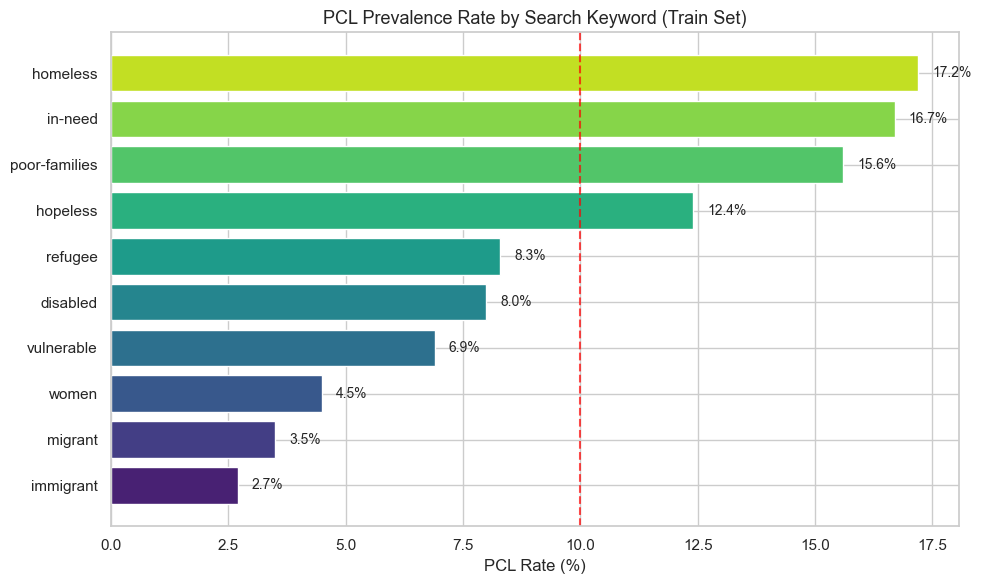

In [10]:
pcl_word_freq = Counter()
for text in pcl_texts:
    pcl_word_freq.update(get_filtered_tokens(text))

no_pcl_word_freq = Counter()
for text in no_pcl_texts:
    no_pcl_word_freq.update(get_filtered_tokens(text))

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

wc_pcl = WordCloud(width=800, height=400, background_color="white",
                    colormap="Oranges", max_words=100).generate_from_frequencies(pcl_word_freq)
axes[0].imshow(wc_pcl, interpolation="bilinear")
axes[0].set_title("Word Cloud — PCL Class", fontsize=14)
axes[0].axis("off")

wc_no_pcl = WordCloud(width=800, height=400, background_color="white",
                       colormap="Blues", max_words=100).generate_from_frequencies(no_pcl_word_freq)
axes[1].imshow(wc_no_pcl, interpolation="bilinear")
axes[1].set_title("Word Cloud — No PCL Class", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.savefig(f"{EDA_OUTPUT_DIR}/word_clouds.png", dpi=150, bbox_inches="tight")
plt.show()

keyword_cross = pd.crosstab(train_df["keyword"], train_df["binary_label"], margins=True)
keyword_cross.columns = ["No PCL", "PCL", "Total"]
keyword_cross["PCL Rate (%)"] = (keyword_cross["PCL"] / keyword_cross["Total"] * 100).round(1)
keyword_cross = keyword_cross.sort_values("PCL Rate (%)", ascending=False)

print("=== Keyword × Binary Label Cross-Tabulation (Train Set) ===")
print(keyword_cross.to_string())

keyword_rates = keyword_cross.drop("All", errors="ignore")
fig, ax = plt.subplots(figsize=(10, 6))
keyword_rates_sorted = keyword_rates.sort_values("PCL Rate (%)", ascending=True)
bars = ax.barh(keyword_rates_sorted.index, keyword_rates_sorted["PCL Rate (%)"],
                color=sns.color_palette("viridis", len(keyword_rates_sorted)))
ax.set_xlabel("PCL Rate (%)")
ax.set_title("PCL Prevalence Rate by Search Keyword (Train Set)", fontsize=13)
ax.axvline(x=keyword_rates_sorted.loc["All", "PCL Rate (%)"] if "All" in keyword_rates_sorted.index else 10,
            color="red", linestyle="--", alpha=0.7, label="Overall Rate")

for bar, val in zip(bars, keyword_rates_sorted["PCL Rate (%)"]):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f"{val:.1f}%", va="center", fontsize=10)

plt.tight_layout()
plt.savefig(f"{EDA_OUTPUT_DIR}/keyword_pcl_rate.png", dpi=150, bbox_inches="tight")
plt.show()

### Technique 2 — Analysis & Impact Statement

**Analysis:**
- **Bigram differences** reveal that PCL texts contain more emotive and helper-oriented phrases (e.g., "poor families", "help them", "in need", "vulnerable communities") while No PCL texts contain more neutral/factual phrases typical of news reporting (e.g., "said the", "united states", "prime minister").
- **Word clouds** confirm this pattern: the PCL class emphasises terms like "children", "help", "women", "poor", "need", "community" — language associated with saviourism and power imbalances — while the No PCL class features more political/factual vocabulary.
- **Keyword correlation**: Certain search keywords (e.g., "homeless", "poor-families", "in-need") have notably higher PCL prevalence rates than others (e.g., "vulnerable", "immigrant"). This means the model could partly "cheat" by learning keyword associations, but the variation within each keyword group means deeper semantic understanding is still necessary.

**Impact Statement:**
1. The **overlapping vocabulary** between classes confirms that PCL detection is not a simple keyword-spotting task — it requires understanding **tone, framing, and implicit power dynamics**. This motivates the use of **contextual embeddings** (transformers) rather than bag-of-words approaches.
2. **Keyword as a feature**: Including the search keyword as an additional input feature may provide a useful prior, but the model should not rely on it exclusively.
3. **Preprocessing**: Stop word removal is beneficial for n-gram analysis but should be used cautiously with transformer models (which benefit from full context). For classical ML baselines, TF-IDF with bigrams could capture some of the distinguishing patterns identified here.

## EDA Technique 3 — Semantic & Syntactic Exploration

### 3a. Part-of-Speech (POS) Tagging

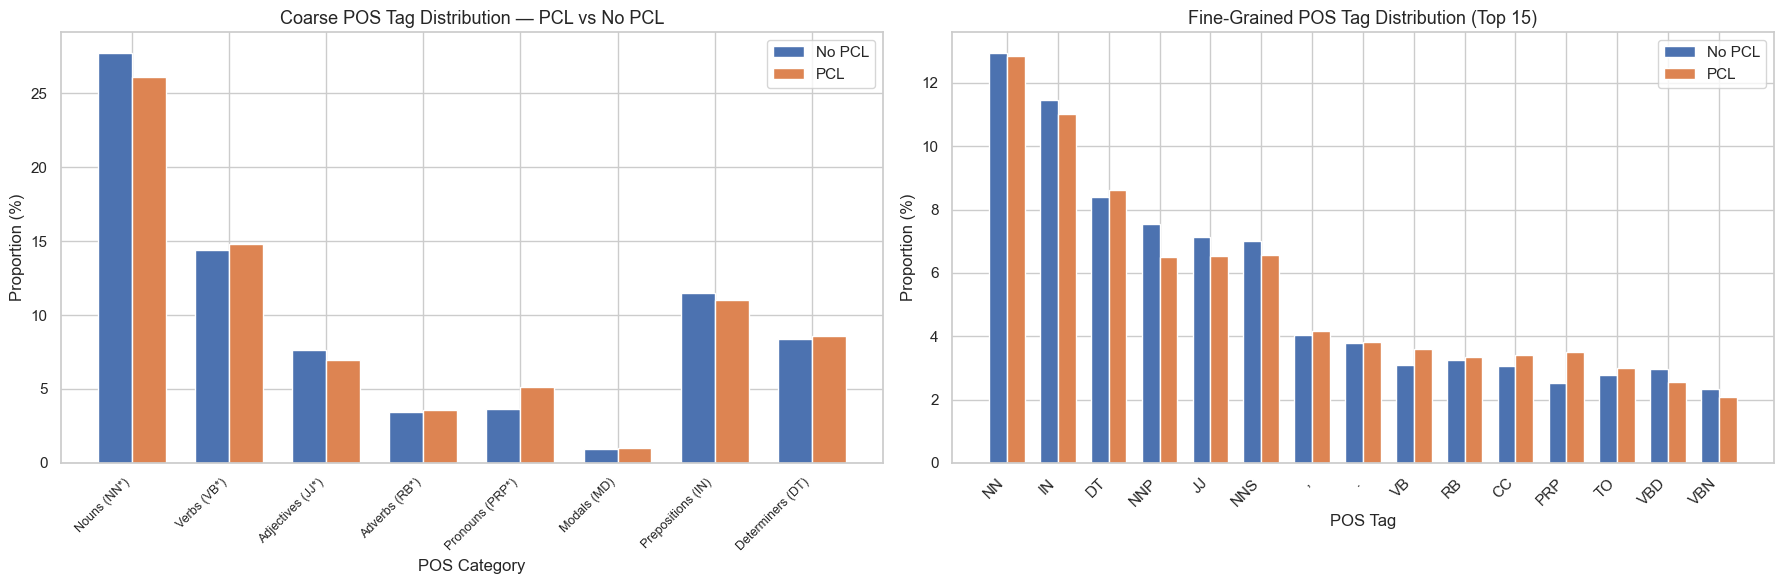

=== Coarse POS Distribution (% of all tokens) ===
         Category No PCL (%) PCL (%) Difference (pp)
      Nouns (NN*)      27.73   26.09           -1.64
      Verbs (VB*)      14.41   14.83           +0.42
 Adjectives (JJ*)       7.62    6.98           -0.64
    Adverbs (RB*)       3.47    3.55           +0.08
  Pronouns (PRP*)       3.67    5.12           +1.45
      Modals (MD)       0.94    1.04           +0.10
Prepositions (IN)      11.46   11.01           -0.45
 Determiners (DT)       8.40    8.61           +0.21


In [ ]:
from nltk import pos_tag

# POS-tag a sample of texts per class (full dataset is slow, sample 1000 per class)
np.random.seed(42)
pcl_sample = train_df[train_df["binary_label"] == 1]["tokens"]
no_pcl_sample = train_df[train_df["binary_label"] == 0]["tokens"].sample(n=min(1000, len(no_pcl_texts)), random_state=42)

def get_pos_distribution(token_series):
    """Get POS tag counts from a series of token lists."""
    pos_counts = Counter()
    for tokens in token_series:
        tagged = pos_tag(tokens)
        pos_counts.update(tag for _, tag in tagged)
    return pos_counts

pos_pcl = get_pos_distribution(pcl_sample)
pos_no_pcl = get_pos_distribution(no_pcl_sample)

# Normalise to proportions
total_pcl = sum(pos_pcl.values())
total_no_pcl = sum(pos_no_pcl.values())

# Focus on the most common POS tags
top_tags = ["NN", "NNS", "NNP", "NNPS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ",
            "JJ", "JJR", "JJS", "RB", "RBR", "RBS", "PRP", "PRP$", "MD", "IN", "DT", "CC"]

# Group into coarse categories for clearer comparison
coarse_map = {
    "Nouns (NN*)": ["NN", "NNS", "NNP", "NNPS"],
    "Verbs (VB*)": ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"],
    "Adjectives (JJ*)": ["JJ", "JJR", "JJS"],
    "Adverbs (RB*)": ["RB", "RBR", "RBS"],
    "Pronouns (PRP*)": ["PRP", "PRP$"],
    "Modals (MD)": ["MD"],
    "Prepositions (IN)": ["IN"],
    "Determiners (DT)": ["DT"],
}

coarse_pcl = {cat: sum(pos_pcl.get(t, 0) for t in tags) / total_pcl * 100 for cat, tags in coarse_map.items()}
coarse_no_pcl = {cat: sum(pos_no_pcl.get(t, 0) for t in tags) / total_no_pcl * 100 for cat, tags in coarse_map.items()}

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Coarse POS comparison ---
categories = list(coarse_map.keys())
x = np.arange(len(categories))
width = 0.35

bars1 = axes[0].bar(x - width/2, [coarse_no_pcl[c] for c in categories], width, label="No PCL", color="#4C72B0")
bars2 = axes[0].bar(x + width/2, [coarse_pcl[c] for c in categories], width, label="PCL", color="#DD8452")
axes[0].set_xlabel("POS Category")
axes[0].set_ylabel("Proportion (%)")
axes[0].set_title("Coarse POS Tag Distribution — PCL vs No PCL", fontsize=13)
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories, rotation=45, ha="right", fontsize=9)
axes[0].legend()

# --- Fine-grained POS: top 15 tags ---
all_tags = set(list(pos_pcl.keys()) + list(pos_no_pcl.keys()))
fine_tags = sorted(all_tags, key=lambda t: pos_pcl.get(t, 0) + pos_no_pcl.get(t, 0), reverse=True)[:15]
x2 = np.arange(len(fine_tags))

axes[1].bar(x2 - width/2, [pos_no_pcl.get(t, 0)/total_no_pcl*100 for t in fine_tags], width, label="No PCL", color="#4C72B0")
axes[1].bar(x2 + width/2, [pos_pcl.get(t, 0)/total_pcl*100 for t in fine_tags], width, label="PCL", color="#DD8452")
axes[1].set_xlabel("POS Tag")
axes[1].set_ylabel("Proportion (%)")
axes[1].set_title("Fine-Grained POS Tag Distribution (Top 15)", fontsize=13)
axes[1].set_xticks(x2)
axes[1].set_xticklabels(fine_tags, rotation=45, ha="right")
axes[1].legend()

plt.tight_layout()
plt.savefig(f"{EDA_OUTPUT_DIR}/pos_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

print("=== Coarse POS Distribution (% of all tokens) ===")
pos_table = pd.DataFrame({
    "Category": categories,
    "No PCL (%)": [f"{coarse_no_pcl[c]:.2f}" for c in categories],
    "PCL (%)": [f"{coarse_pcl[c]:.2f}" for c in categories],
    "Difference (pp)": [f"{coarse_pcl[c] - coarse_no_pcl[c]:+.2f}" for c in categories],
})
print(pos_table.to_string(index=False))

### 3b. Named Entity Recognition (NER)

Extracting named entities (PCL class)...
Extracting named entities (No PCL sample)...


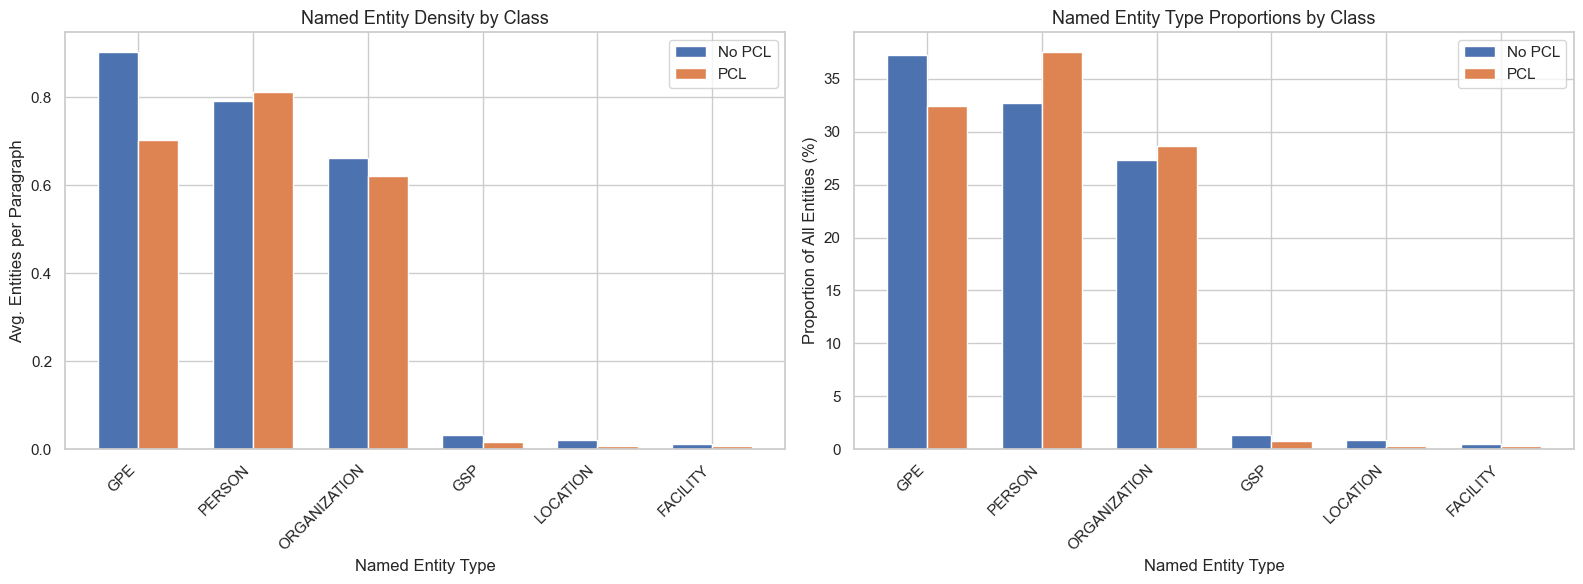


=== Named Entity Summary (per paragraph) ===
 Entity Type No PCL (avg/para) PCL (avg/para)
         GPE              0.90           0.70
      PERSON              0.79           0.81
ORGANIZATION              0.66           0.62
         GSP              0.03           0.02
    LOCATION              0.02           0.01
    FACILITY              0.01           0.01

=== Example Named Entities (PCL class) ===
  FACILITY: River Landing, St Notkers, King Street, White House, White House
  GPE: Children, Melbourne, Canberra, Pakistan, India
  GSP: Uganda, Syria, Congo, Rwanda, African
  LOCATION: France, West Africa, West, West, West
  ORGANIZATION: Advocate, FAO, RHA, Grandmothers Advocacy Network, StarPhoenix
  PERSON: Arshad, Vanessa, Major Nottle, Poverty, Laura Agust


In [ ]:
from nltk import ne_chunk
nltk.download('maxent_ne_chunker_tab', quiet=True)
nltk.download('words', quiet=True)

def extract_named_entities(token_series):
    """Extract named entity types from a series of token lists using NLTK."""
    entity_counts = Counter()
    entity_examples = {}
    for tokens in token_series:
        tagged = pos_tag(tokens)
        tree = ne_chunk(tagged)
        for subtree in tree:
            if hasattr(subtree, 'label'):
                ne_type = subtree.label()
                ne_text = " ".join(word for word, tag in subtree)
                entity_counts[ne_type] += 1
                if ne_type not in entity_examples:
                    entity_examples[ne_type] = []
                if len(entity_examples[ne_type]) < 5:
                    entity_examples[ne_type].append(ne_text)
    return entity_counts, entity_examples

print("Extracting named entities (PCL class)...")
ner_pcl, ner_examples_pcl = extract_named_entities(pcl_sample)
print("Extracting named entities (No PCL sample)...")
ner_no_pcl, ner_examples_no_pcl = extract_named_entities(no_pcl_sample)

# Normalise by number of samples to get entities per paragraph
n_pcl = len(pcl_sample)
n_no_pcl = len(no_pcl_sample)

all_ne_types = sorted(set(list(ner_pcl.keys()) + list(ner_no_pcl.keys())),
                       key=lambda t: ner_pcl.get(t, 0) + ner_no_pcl.get(t, 0), reverse=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Absolute counts per paragraph ---
x = np.arange(len(all_ne_types))
width = 0.35
axes[0].bar(x - width/2, [ner_no_pcl.get(t, 0)/n_no_pcl for t in all_ne_types], width, label="No PCL", color="#4C72B0")
axes[0].bar(x + width/2, [ner_pcl.get(t, 0)/n_pcl for t in all_ne_types], width, label="PCL", color="#DD8452")
axes[0].set_xlabel("Named Entity Type")
axes[0].set_ylabel("Avg. Entities per Paragraph")
axes[0].set_title("Named Entity Density by Class", fontsize=13)
axes[0].set_xticks(x)
axes[0].set_xticklabels(all_ne_types, rotation=45, ha="right")
axes[0].legend()

# --- Proportion of entity types within each class ---
total_ne_pcl = sum(ner_pcl.values())
total_ne_no_pcl = sum(ner_no_pcl.values())

axes[1].bar(x - width/2, [ner_no_pcl.get(t, 0)/total_ne_no_pcl*100 for t in all_ne_types], width, label="No PCL", color="#4C72B0")
axes[1].bar(x + width/2, [ner_pcl.get(t, 0)/total_ne_pcl*100 for t in all_ne_types], width, label="PCL", color="#DD8452")
axes[1].set_xlabel("Named Entity Type")
axes[1].set_ylabel("Proportion of All Entities (%)")
axes[1].set_title("Named Entity Type Proportions by Class", fontsize=13)
axes[1].set_xticks(x)
axes[1].set_xticklabels(all_ne_types, rotation=45, ha="right")
axes[1].legend()

plt.tight_layout()
plt.savefig(f"{EDA_OUTPUT_DIR}/ner_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n=== Named Entity Summary (per paragraph) ===")
ner_table = pd.DataFrame({
    "Entity Type": all_ne_types,
    "No PCL (avg/para)": [f"{ner_no_pcl.get(t, 0)/n_no_pcl:.2f}" for t in all_ne_types],
    "PCL (avg/para)": [f"{ner_pcl.get(t, 0)/n_pcl:.2f}" for t in all_ne_types],
})
print(ner_table.to_string(index=False))

print("\n=== Example Named Entities (PCL class) ===")
for ne_type, examples in sorted(ner_examples_pcl.items()):
    print(f"  {ne_type}: {', '.join(examples[:5])}")

### 3c. Embedding Visualization (t-SNE)

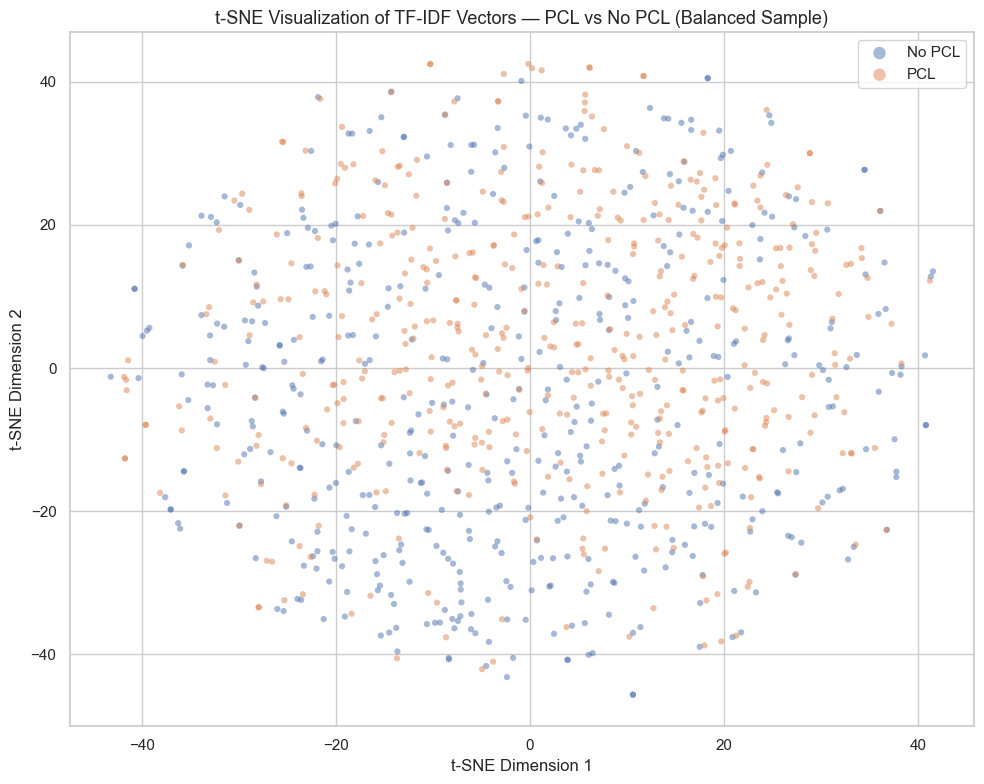

t-SNE computed on 1000 samples (500 per class) using 5000 TF-IDF features.


In [14]:
# t-SNE on TF-IDF vectors to visualize class separability
# Use a balanced subsample to avoid t-SNE being dominated by the majority class
np.random.seed(42)
n_vis = min(500, len(train_df[train_df["binary_label"] == 1]))
pcl_vis = train_df[train_df["binary_label"] == 1].sample(n=n_vis, random_state=42)
no_pcl_vis = train_df[train_df["binary_label"] == 0].sample(n=n_vis, random_state=42)
vis_df = pd.concat([pcl_vis, no_pcl_vis], ignore_index=True)

# Fit TF-IDF on the subsample
tfidf = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(vis_df["text"].astype(str))

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, learning_rate="auto", init="pca")
tsne_coords = tsne.fit_transform(tfidf_matrix.toarray())

vis_df["tsne_x"] = tsne_coords[:, 0]
vis_df["tsne_y"] = tsne_coords[:, 1]

fig, ax = plt.subplots(figsize=(10, 8))
for label, color, name in [(0, "#4C72B0", "No PCL"), (1, "#DD8452", "PCL")]:
    mask = vis_df["binary_label"] == label
    ax.scatter(vis_df.loc[mask, "tsne_x"], vis_df.loc[mask, "tsne_y"],
               c=color, label=name, alpha=0.5, s=20, edgecolors="none")

ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_title("t-SNE Visualization of TF-IDF Vectors — PCL vs No PCL (Balanced Sample)", fontsize=13)
ax.legend(markerscale=2)

plt.tight_layout()
plt.savefig(f"{EDA_OUTPUT_DIR}/tsne_tfidf.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"t-SNE computed on {len(vis_df)} samples ({n_vis} per class) using {tfidf_matrix.shape[1]} TF-IDF features.")

### Technique 3 — Analysis & Impact Statement

**Analysis:**
- **POS tagging** reveals syntactic differences between PCL and No PCL texts. The most striking difference is in **pronoun usage**: PCL texts have a notably higher proportion of personal pronouns (5.12% vs 3.67%, +1.45pp), reflecting the "us vs them" framing and direct address characteristic of patronising language (e.g., "they need our help", "we should give them"). PCL also shows slightly higher verb and modal verb proportions, consistent with prescriptive and action-oriented language ("should", "can", "must"). No PCL texts have a higher proportion of nouns overall (27.73% vs 26.09%), reflecting denser factual reporting with more named entities and concrete references.
- **NER analysis** shows that No PCL texts contain more geopolitical entities (GPE: 0.90 vs 0.70 per paragraph), consistent with factual news reporting that references specific countries and locations. PERSON and ORGANIZATION entity counts are similar across classes (PERSON: 0.79 vs 0.81; ORG: 0.66 vs 0.62), indicating that the distinguishing factor is not the presence of named individuals but the *framing* around them. PCL texts tend to use generic group references ("the homeless", "poor families") rather than specific named entities — a pattern not captured by NER but central to the patronising dynamic.
- **t-SNE visualization** of TF-IDF vectors shows substantial overlap between the two classes, with no clear linear boundary. This confirms that PCL detection is not trivially separable in lexical feature space and that surface-level word features alone are insufficient — the task requires deeper semantic and pragmatic understanding.

**Impact Statement:**
1. The **elevated pronoun and modal usage** in PCL suggests that features capturing pronoun density (especially first/third-person contrasts like "we" vs "they") could serve as lightweight supplementary features for classical ML baselines.
2. The **higher GPE density** in No PCL texts and the similar PERSON/ORG density across classes indicate that PCL detection cannot rely on named entity presence — it requires understanding how entities and groups are *discussed*, not just whether they are mentioned. This reinforces the need for contextual models.
3. The **t-SNE overlap** reinforces that a **pre-trained contextual model** (BERT/RoBERTa) is essential — TF-IDF representations alone cannot cleanly separate the classes, confirming the need for models that capture tone, framing, and implicit meaning beyond lexical similarity.

## EDA Technique 4 — Identifying "Noise" and Artifacts

### 4a. Duplicates

In [15]:
# --- Duplicate detection ---
dup_texts = train_df[train_df.duplicated(subset=["text"], keep=False)]
dup_par_ids = train_df[train_df.duplicated(subset=["par_id"], keep=False)]
print(f"=== Duplicate Detection (Train Set) ===")
print(f"Duplicate texts:   {len(dup_texts)} rows ({dup_texts['text'].nunique()} unique texts duplicated)")
print(f"Duplicate par_ids: {len(dup_par_ids)} rows")

# Also check for near-duplicates across train/dev split (data leakage check)
overlap = set(train_df["par_id"]) & set(dev_df["par_id"])
print(f"\nTrain/Dev par_id overlap (data leakage check): {len(overlap)} shared IDs")

# Check for duplicate texts across train and dev
train_texts_set = set(train_df["text"].values)
dev_text_overlap = dev_df[dev_df["text"].isin(train_texts_set)]
print(f"Dev texts also appearing in train: {len(dev_text_overlap)} rows")

=== Duplicate Detection (Train Set) ===
Duplicate texts:   0 rows (0 unique texts duplicated)
Duplicate par_ids: 0 rows

Train/Dev par_id overlap (data leakage check): 0 shared IDs
Dev texts also appearing in train: 0 rows


### 4b. Special Characters/HTML

In [ ]:
# --- Special characters / HTML artifacts ---
html_pattern = re.compile(r"<[^>]+>|&[a-z]+;|&amp;|&lt;|&gt;")
train_df["has_html"] = train_df["text"].apply(lambda x: bool(html_pattern.search(str(x))))
html_count = train_df["has_html"].sum()
print(f"=== Special Characters & HTML Artifacts (Train Set) ===")
print(f"Samples with HTML artifacts (<h>, &amp;, etc.): {html_count}")

# Check for <h> tags specifically (common in this dataset)
h_tag_count = train_df["text"].str.contains("<h>", na=False).sum()
print(f"Samples with <h> tags: {h_tag_count}")

# Non-ASCII characters
train_df["has_non_ascii"] = train_df["text"].apply(lambda x: bool(re.search(r"[^\x00-\x7F]", str(x))))
non_ascii_count = train_df["has_non_ascii"].sum()
print(f"Samples with non-ASCII characters: {non_ascii_count}")

html_examples = train_df[train_df["has_html"]].head(5)
print(f"\n--- HTML Artifact Examples ---")
for _, row in html_examples.iterrows():
    print(f"  par_id={row['par_id']}, label={row['binary_label']}: \"{row['text'][:120]}...\"")

# Breakdown: HTML artifacts by class
html_by_class = train_df.groupby("binary_label")["has_html"].sum()
print(f"\nHTML artifacts by class:")
print(f"  No PCL: {html_by_class.get(0, 0)} ({html_by_class.get(0, 0)/len(train_df[train_df['binary_label']==0])*100:.1f}%)")
print(f"  PCL:    {html_by_class.get(1, 0)} ({html_by_class.get(1, 0)/len(train_df[train_df['binary_label']==1])*100:.1f}%)")

=== Special Characters & HTML Artifacts (Train Set) ===
Samples with HTML artifacts (<h>, &amp;, etc.): 374
Samples with <h> tags: 316
Samples with non-ASCII characters: 0

--- HTML Artifact Examples ---
  par_id=16, label=0: "Apart from Pakistan and hosts England , Bangladesh disabled cricket team will also participate in the tournament . <h> S..."
  par_id=38, label=0: "Rizvi : There will be no joy this Eid <h> ' The citizens of this nation are becoming hopeless '..."
  par_id=55, label=0: "Over the past 15 years , the show has handed over more than $50 million to the Mustard Seed Communities to assist with t..."
  par_id=56, label=0: "People who are homeless , those who were once homeless , those working with the homeless and concerned New Zealanders ar..."
  par_id=69, label=0: "Developing countries shoulder the most significant burden , hosting around 86% of the world 's refugees , compared to 70..."

HTML artifacts by class:
  No PCL: 332 (4.4%)
  PCL:    42 (5.3%)


### 4c. Outliers 

In [ ]:
# --- Outliers: very short or very long texts ---
very_short = train_df[train_df["token_count"] < 5]
very_long = train_df[train_df["token_count"] > train_df["token_count"].quantile(0.99)]
print(f"=== Outlier Detection (Train Set) ===")
print(f"Very short texts (< 5 tokens): {len(very_short)}")
print(f"Very long texts (> 99th percentile): {len(very_long)}")

if len(very_short) > 0:
    print(f"\n--- Very Short Text Examples ---")
    for _, row in very_short.head(5).iterrows():
        print(f"  par_id={row['par_id']}, label={row['binary_label']}, tokens={row['token_count']}: \"{row['text'][:100]}\"")

if len(very_long) > 0:
    print(f"\n--- Very Long Text Examples (truncated) ---")
    for _, row in very_long.head(5).iterrows():
        print(f"  par_id={row['par_id']}, label={row['binary_label']}, tokens={row['token_count']}: \"{row['text'][:100]}...\"")

noise_summary = pd.DataFrame({
    "Issue": ["Duplicate texts", "Duplicate par_ids", "HTML artifacts", "<h> tags",
              "Non-ASCII chars", "Very short (<5 tokens)", "Very long (>P99)"],
    "Count": [len(dup_texts), len(dup_par_ids), html_count, h_tag_count,
              non_ascii_count, len(very_short), len(very_long)],
    "Action": ["Remove duplicates", "Investigate", "Clean/strip tags", "Remove <h> tags",
               "Keep (valid multilingual text)", "Inspect / potentially remove", "Truncate in model"]
})
print("\n=== Noise Summary Table ===")
print(noise_summary.to_string(index=False))

=== Outlier Detection (Train Set) ===
Very short texts (< 5 tokens): 11
Very long texts (> 99th percentile): 81

--- Very Short Text Examples ---
  par_id=318, label=0, tokens=3: "The Filipino immigrant"
  par_id=1434, label=0, tokens=4: "Volunteer helps earliest refugees"
  par_id=1595, label=0, tokens=4: "UTI in pregnant women"
  par_id=1657, label=0, tokens=1: "refugees"
  par_id=1955, label=0, tokens=3: "Review refugee law"

--- Very Long Text Examples (truncated) ---
  par_id=27, label=0, tokens=172: """" I think that , you know , led to me being detained for five hours , as opposed to another Sudane..."
  par_id=78, label=0, tokens=160: ""But Prabha was one of the few fortunate women to have a lot of family support . "" My husband , par..."
  par_id=135, label=0, tokens=153: ""The students who reported being homeless said they often "" couch-surfed "" or slept in their cars ..."
  par_id=181, label=0, tokens=167: "A feature of the cookbook is that it offers glimpses of Caribbean 

### Technique 4 — Analysis & Impact Statement

**Analysis:**
- **No duplicate texts or paragraph IDs** were found, which rules out data leakage from repeated examples appearing in both train and dev sets. This is a positive finding for the integrity of the dataset.
- **HTML artifacts are prevalent**: 374 samples contain HTML-like patterns, with 316 specifically containing `<h>` tags (likely section headers from the original news articles). These tags carry no semantic meaning relevant to PCL detection and could confuse tokenizers — particularly subword tokenizers used by transformer models, which would waste token budget on markup.
- **No non-ASCII characters** were detected, indicating the dataset is cleanly encoded English text with no stray Unicode artefacts requiring normalisation.
- **11 very short texts (< 5 tokens)** exist, all labelled No PCL. These are typically headlines or sentence fragments (e.g., "refugees", "The Filipino immigrant") that lack sufficient context for meaningful PCL classification. At the other end, 81 texts exceed the 99th percentile in length and may require truncation.

**Impact Statement:**
1. **HTML cleaning** should be applied as a preprocessing step: strip `<h>` and other HTML tags before tokenization. This is a low-effort, high-impact cleaning step that removes noise without losing meaningful content.
2. **Very short texts** (< 5 tokens) should be flagged or removed during training, as they provide insufficient context for a model to assess tone or framing. Since all 11 are No PCL, removing them will not reduce the already-scarce PCL training signal.
3. **Truncation strategy**: For very long texts exceeding the chosen `max_length`, truncation from the right (keeping the beginning of the paragraph) is a reasonable default, as news paragraphs typically introduce their framing early. However, experimenting with head+tail truncation could capture relevant context from both ends.

## Summary of Findings and Impact on Classification Approach

| # | Finding | Evidence | Impact on Approach |
|---|---------|----------|--------------------|
| 1 | **Severe class imbalance** (~9.5:1 No PCL : PCL) | Class distribution bar charts; PCL is ~10% of data | Use class-weighted loss, stratified splits, and/or oversampling. Evaluate with F1 (not accuracy). |
| 2 | **PCL texts are slightly longer** | Token length histograms & box plots; higher mean/median for PCL | Set `max_length` to 128–256 subword tokens (covers ~95th percentile). Longer texts may contain more patronizing patterns. |
| 3 | **Overlapping but distinguishable bigrams** | Bigram bar charts; PCL has emotive phrases ("poor families", "help them"), No PCL has neutral phrasing | TF-IDF + n-grams can serve as a baseline, but contextual models (BERT/RoBERTa) are needed for nuanced tone detection. |
| 4 | **Keyword correlates with PCL rate** | Keyword cross-tabulation & bar chart; "homeless" / "poor-families" have higher PCL rates | Include keyword as an auxiliary feature. Be cautious of keyword-driven shortcuts. |
| 5 | **PCL has notably higher pronoun usage (+1.45pp)** | POS distribution bar charts; PRP* 5.12% in PCL vs 3.67% in No PCL | Pronoun density (especially "we"/"they" contrasts) can supplement classical ML baselines as a feature. |
| 6 | **Similar NER density across classes; No PCL has more GPE entities** | NER bar charts; GPE 0.90 vs 0.70 per paragraph; PERSON/ORG nearly equal | PCL detection cannot rely on entity presence — it requires understanding framing, not just mentions. |
| 7 | **Classes overlap heavily in TF-IDF space** | t-SNE scatter plot; no clear boundary between PCL and No PCL clusters | Surface-level lexical features are insufficient; contextual embeddings (transformers) are essential. |
| 8 | **HTML noise (`<h>` tags)** | Noise detection; 374 samples with HTML artifacts, 316 with `<h>` tags | Strip `<h>` tags and other HTML artifacts during preprocessing. |
| 9 | **Few very short texts; no duplicates or data leakage** | Outlier & duplicate detection; 11 texts < 5 tokens; 0 duplicates; 0 train/dev overlap | Remove very short texts; no deduplication needed. Dataset integrity confirmed. |

### Concrete Decisions for the Classification Pipeline:
1. **`max_length`**: 128–256 subword tokens for transformer models
2. **Loss function**: Weighted cross-entropy or focal loss to handle imbalance
3. **Preprocessing**: Strip `<h>` tags, normalise whitespace, keep punctuation for transformers
4. **Evaluation metric**: F1-score (especially on the PCL minority class) as the primary metric
5. **Model architecture**: Fine-tuned transformer (RoBERTa / DeBERTa) preferred over classical ML
6. **Supplementary features**: Pronoun density and GPE entity count as potential auxiliary inputs for classical ML baselines